# Automated ML

TODO: Import Dependencies. In the cell below, import all the dependencies that you will need to complete the project.

In [5]:
 
import numpy as np
import math
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt  
from matplotlib.pyplot import figure
from scipy.stats import norm
#!pip install pandas_datareader
from pandas_datareader import data
import urllib.request
import json
import os
import ssl
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
 
from azureml.core import Workspace, Dataset, Experiment, Run
from azureml.train.automl import AutoMLConfig
from azureml.widgets import RunDetails
from azureml.core.compute import AmlCompute, ComputeTarget
from azureml.core.compute_target import ComputeTargetException
from azureml.train.automl.run import AutoMLRun
from azureml.core.model import Model, InferenceConfig
from azureml.core.environment import Environment
from azureml.core.webservice import AciWebservice
from azureml.train.hyperdrive import HyperDriveRun
from azureml.train.dnn import TensorFlow
from azureml.train.hyperdrive import RandomParameterSampling, BanditPolicy, HyperDriveConfig, PrimaryMetricGoal

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, Callback
import tensorflow.keras as tf

 

## Dataset

### Overview
TODO: In this markdown cell, give an overview of the dataset you are using. Also mention the task you will be performing.


TODO: Get data. In the cell below, write code to access the data you will be using in this project. Remember that the dataset needs to be external.

In [6]:
ws = Workspace.from_config()
# choose a name for experiment
experiment_name = 'MSFT-stock'
experiment=Experiment(ws, experiment_name)

# Data prepration

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Adj Close')

<Figure size 432x288 with 0 Axes>

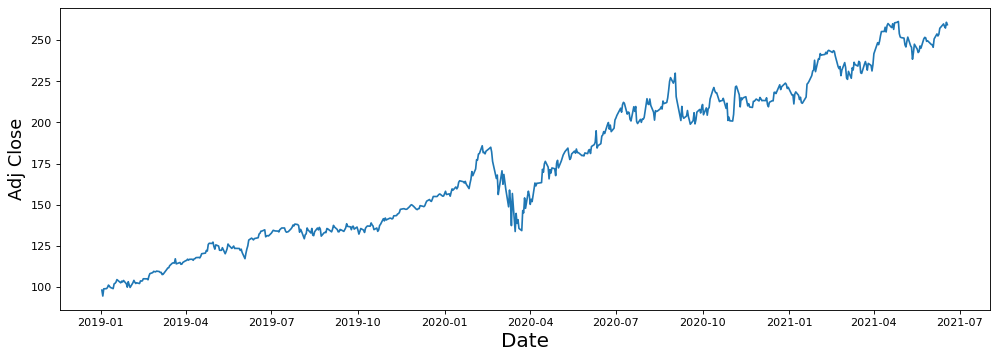

In [7]:
#download MSFT price data into DataFrame
MSFT = data.DataReader('MSFT', 'yahoo',start='1/1/2019')
MSFT = MSFT.reset_index()
X = MSFT[['Date','Adj Close']] 
fig = plt.figure( )
figure(figsize=(15,5), dpi=80)  
plt.plot(X['Date'], X['Adj Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel("Adj Close", fontsize=16)

In [8]:
X=X.reset_index(drop =True)
# Split the dataframe 
split_date ='2021-01-01'
X_train = X.loc[X['Date'] <= split_date]
X_test = X.loc[X['Date'] > split_date]
X_train.set_index('Date', inplace=True)
X_test.set_index('Date', inplace=True)
X_test=X_test.resample('D').ffill().reset_index()
X_train=X_train.resample('D').ffill().reset_index()
X_train.set_index('Date', inplace=True)
X_test.set_index('Date', inplace=True)
#pd.date_range(start = '2019-01-01', end = '2021-01-01' ).difference(X_train.index)
X_test.head()

,Adj Close
Date,
2021-01-04,216.689423
2021-01-05,216.898438
2021-01-06,211.274414
2021-01-07,217.286652
2021-01-08,218.610550


# Register Data

In [9]:
UPDATE_DATASET = True

if UPDATE_DATASET:    
    path = 'Data'
    try:
        os.mkdir(path,)
    except OSError as err:
        print(err)
    else:
        print('Directory %s succesfully created' %path)
    local_path = './Data/MSFT_train.csv'
    local_path_test = './Data/MSFT_test.csv'
    X_train.to_csv(local_path)
    X_test.to_csv(local_path_test)
    # get the datastore to upload prepared data
    datastore = ws.get_default_datastore()
    # upload the local file from src_dir to the target_path in datastore
    datastore.upload(src_dir='Data', target_path='Data', overwrite=True, show_progress=True)
    # create a dataset referencing the cloud location
    dataset_train = Dataset.Tabular.from_delimited_files(path = [(datastore, (local_path))])
    dataset_test = Dataset.Tabular.from_delimited_files(path = [(datastore, (local_path_test))])
    # Register the Dataset
    dataset_train = dataset_train.register(workspace=ws,
                                 name='MSFT-stock cleaned',
                                 description='MSFT-stock test cleaned',
                                 create_new_version=True)

    dataset_test = dataset_test.register(workspace=ws,
                                 name='MSFT-stock test cleaned',
                                 description='MSFT-stock test cleaned',
                                 create_new_version=True)

if not UPDATE_DATASET:
    dataset_train = Dataset.get_by_name(ws, name='MSFT-stock cleaned')
    dataset_test  = Dataset.get_by_name(ws, name='MSFT-stock test cleaned')
df_train = dataset_train.to_pandas_dataframe()
df_train  = df_train .set_index('Date', inplace=False) 
df_test = dataset_test .to_pandas_dataframe()
df_test = df_test.set_index('Date', inplace=False)

[Errno 17] File exists: 'Data'
Uploading an estimated of 4 files
Uploading Data/.amlignore
Uploaded Data/.amlignore, 1 files out of an estimated total of 4
Uploading Data/.amlignore.amltmp
Uploaded Data/.amlignore.amltmp, 2 files out of an estimated total of 4
Uploading Data/MSFT_test.csv
Uploaded Data/MSFT_test.csv, 3 files out of an estimated total of 4
Uploading Data/MSFT_train.csv
Uploaded Data/MSFT_train.csv, 4 files out of an estimated total of 4
Uploaded 4 files


## AutoML Configuration

TODO: Explain why you chose the automl settings and cofiguration you used below.

In [10]:
# CPU cluster name
amlcompute_cluster_name = "automl-forecast"

# Verify that cluster does not exist already
try:
    compute_target = ComputeTarget(workspace=ws, name=amlcompute_cluster_name)
    print('Found existing cluster, use it.')
except ComputeTargetException:
    print('No cluster found')
    compute_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_DS3_V2',                                                           
                                                           max_nodes=4,
                                                          min_nodes = 1, idle_seconds_before_scaledown = 600)
    compute_target = ComputeTarget.create(ws, amlcompute_cluster_name, compute_config)

compute_target.wait_for_completion(show_output=True)

Found existing cluster, use it.

Running


In [11]:
# TODO: Put your automl settings here
automl_settings = {
    "experiment_timeout_minutes":30,
    "max_concurrent_iterations":4,
    "primary_metric": "normalized_root_mean_squared_error",
    'time_column_name': 'Date'
}

# TODO: Put your automl config here
automl_config = AutoMLConfig(compute_target=compute_target,
                             task = "forecasting",
                             training_data=dataset_train,
                             label_column_name="Adj Close",
                             enable_early_stopping= True,
                             n_cross_validations=5,
                             featurization= 'auto',
                             debug_log = "automl_errors.log",
                             **automl_settings
                            )

In [12]:
# TODO: Submit your experiment
remote_run = experiment.submit(automl_config, show_output = True)
remote_run.wait_for_completion()
 

Submitting remote run.
No run_configuration provided, running on automl-forecast with default configuration
Running on remote compute: automl-forecast


Experiment,Id,Type,Status,Details Page,Docs Page
MSFT-stock,AutoML_b9a601f1-07c4-4721-9e88-8cc93c5638bd,automl,NotStarted,Link to Azure Machine Learning studio,Link to Documentation



Current status: ModelSelection. Beginning model selection.

****************************************************************************************************
DATA GUARDRAILS: 

TYPE:         Short series handling
STATUS:       PASSED
DESCRIPTION:  Automated ML detected enough data points for each series in the input data to continue with training.
              

****************************************************************************************************

TYPE:         Frequency detection
STATUS:       PASSED
DESCRIPTION:  The time series was analyzed, all data points are aligned with detected frequency.
              

****************************************************************************************************

TYPE:         Missing feature values imputation
STATUS:       PASSED
DESCRIPTION:  No feature missing values were detected in the training data.
              Learn more about missing value imputation: https://aka.ms/AutomatedMLFeaturization

***************

{'runId': 'AutoML_b9a601f1-07c4-4721-9e88-8cc93c5638bd',
 'target': 'automl-forecast',
 'status': 'Completed',
 'startTimeUtc': '2021-06-18T20:02:42.725563Z',
 'endTimeUtc': '2021-06-18T20:21:11.939544Z',
 'properties': {'num_iterations': '1000',
  'training_type': 'TrainFull',
  'acquisition_function': 'EI',
  'primary_metric': 'normalized_root_mean_squared_error',
  'train_split': '0',
  'acquisition_parameter': '0',
  'num_cross_validation': '5',
  'target': 'automl-forecast',
  'AMLSettingsJsonString': '{"path":null,"name":"MSFT-stock","subscription_id":"a8f8e94b-3b2d-46ad-94ba-2d2f59aa4dd5","resource_group":"athenadev","workspace_name":"ml-cscp-acs-sandeep-dev","region":"westus2","compute_target":"automl-forecast","spark_service":null,"azure_service":"remote","many_models":false,"pipeline_fetch_max_batch_size":1,"enable_batch_run":false,"enable_run_restructure":false,"start_auxiliary_runs_before_parent_complete":false,"enable_code_generation":false,"iterations":1000,"primary_metri

## Run Details

OPTIONAL: Write about the different models trained and their performance. Why do you think some models did better than others?

TODO: In the cell below, use the `RunDetails` widget to show the different experiments.

In [13]:
RunDetails(remote_run).show()

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', 's…

## Best Model

TODO: In the cell below, get the best model from the automl experiments and display all the properties of the model.



In [14]:
# Retrieve and save your best automl model.

best_run, best_model = remote_run.get_output()
print(best_run.id)
print(best_run.get_metrics()['mean_absolute_error'])
print(best_run.get_metrics()['root_mean_squared_error'])

Package:azureml-automl-runtime, training version:1.30.0, current version:1.28.0.post2
Package:azureml-core, training version:1.30.0, current version:1.28.0
Package:azureml-dataset-runtime, training version:1.30.0, current version:1.28.0
Package:azureml-defaults, training version:1.30.0, current version:1.28.0
Package:azureml-interpret, training version:1.30.0, current version:1.28.0
Package:azureml-mlflow, training version:1.30.0, current version:1.28.0
Package:azureml-pipeline-core, training version:1.30.0, current version:1.28.0
Package:azureml-telemetry, training version:1.30.0, current version:1.28.0
Package:azureml-train-automl-client, training version:1.30.0, current version:1.28.0
Package:azureml-train-automl-runtime, training version:1.30.0, current version:1.28.0
ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


AutoML_b9a601f1-07c4-4721-9e88-8cc93c5638bd_37
0.8677791395635268
0.8677791395635268


In [15]:
#TODO: Save the best model
import joblib
os.makedirs('outputs/', exist_ok=True)
joblib.dump(best_model, filename='outputs/automl.joblib')
!ls ./outputs/


HD_1cd52644-3634-43dc-8d8a-ab2c9d3cff2b_28  automl.joblib
HD_1ef12d9c-ce4a-43af-be8d-af0f1e1f4a9f_18  envFile.yml
HD_3415d846-82c4-4fec-8b30-22fe2654db40_11  score.py


In [18]:
# Register the best model in ws
model_name = best_run.properties['model_name']
model = remote_run.register_model(model_name=model_name, description="MSstock", tags=None)
remote_run.model_id # Use this id to deploy the model as a web service in Azure


'AutoMLb9a601f1037'

## Model Deployment

Remember you have to deploy only one of the two models you trained.. Perform the steps in the rest of this notebook only if you wish to deploy this model.

TODO: In the cell below, register the model, create an inference config and deploy the model as a web service.

In [19]:
from azureml.automl.core.shared import constants
best_run.download_file('./outputs/scoring_file_v_1_0_0.py', 'score.py')
best_run.download_file(constants.CONDA_ENV_FILE_PATH, 'envFile.yml')

In [20]:
service_name = 'msstock2-automl'
 
# Create an inference config from the autoML output files
inference_config = InferenceConfig(entry_script='score.py',
                                  conda_file = 'envFile.yml',
                                  source_directory='./outputs/',
                                  description='MS stock predicton',
                                  runtime='python'
                                  )

# Create a deployment config with an Azure Container Instance
aci_config = AciWebservice.deploy_configuration(cpu_cores=1, memory_gb=1, auth_enabled=True)

# Deploy the model and check the deployment status
service = Model.deploy(workspace=ws,
                      name=service_name,
                      models=[model],
                      inference_config=inference_config,
                      deployment_config=aci_config
                      )

service.wait_for_deployment(show_output=True)
print(service.state)

Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running
2021-06-18 20:28:32+00:00 Creating Container Registry if not exists.
2021-06-18 20:28:32+00:00 Registering the environment.
2021-06-18 20:28:33+00:00 Use the existing image.
2021-06-18 20:28:33+00:00 Generating deployment configuration.
2021-06-18 20:28:34+00:00 Submitting deployment to compute..
2021-06-18 20:28:38+00:00 Checking the status of deployment msstock2-automl..
2021-06-18 20:34:28+00:00 Checking the status of inference endpoint msstock2-automl.
Succeeded
ACI service creation operation finished, operation "Succeeded"
Healthy


In [21]:
print(service.scoring_uri)

http://fede16e3-81f3-46f7-8397-f902c81b513e.westus2.azurecontainer.io/score


TODO: In the cell below, send a request to the web service you deployed to test it.

In [22]:
service.wait_for_deployment(True)
print('/n', service.state)
print(service.scoring_uri)
print(service.swagger_uri)

Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
SucceededACI service creation operation finished, operation "Succeeded"
/n Healthy
http://fede16e3-81f3-46f7-8397-f902c81b513e.westus2.azurecontainer.io/score
http://fede16e3-81f3-46f7-8397-f902c81b513e.westus2.azurecontainer.io/swagger.json


In [23]:
def allowSelfSignedHttps(allowed):
    if allowed and not os.environ.get('PYTHONHTTPSVERIFY', '') and getattr(ssl, '_create_unverified_context', None):
        ssl._create_default_https_context = ssl._create_unverified_context
        

In [31]:
data = {
    "data":
    [
        {
            'Date': "2021-01-04 00:00:00,000000",
        },
        {
            'Date': "2021-01-05 00:00:00,000000",
        },
        {
            'Date': "2021-01-06 00:00:00,000000",

        }
    ],
}
body = str.encode(json.dumps(data))
url = service.scoring_uri
api_key, api_key_secondary = service.get_keys() # Replace this with the API key for the web service
headers = {'Content-Type':'application/json', 'Authorization':('Bearer '+ api_key)}
req = urllib.request.Request(url, body, headers)

In [32]:
try:
    response = urllib.request.urlopen(req)
    result = response.read()
    y = json.loads(json.loads(result))
    print('Janury prediction for MSTock is {}'.format(y['forecast'][2]))  
except urllib.error.HTTPError as error:
    print("The request failed with status code: " + str(error.code))
    print(error.info())
    print(json.loads(error.read().decode("utf8", 'ignore')))

Janury prediction for MSTock is 197.07581345251285


In [33]:

df_prediction = df_test.copy()
df_prediction.reset_index(inplace=True)
split_date ='2021-01-04'
df_prediction =df_prediction.loc[df_prediction['Date'] == split_date]
df_prediction.set_index('Date', inplace=True)

df_prediction['forecast']=y['forecast'][2]
print(df_prediction)


            Adj Close  forecast
Date                           
2021-01-04     216.69    197.08


TODO: In the cell below, print the logs of the web service and delete the service

In [27]:
# Print the logs

print(service.get_logs())

2021-06-18T20:34:17,353108900+00:00 - rsyslog/run 
2021-06-18T20:34:17,360933700+00:00 - gunicorn/run 
2021-06-18T20:34:17,354831600+00:00 - iot-server/run 
2021-06-18T20:34:17,376785000+00:00 - nginx/run 
rsyslogd: /azureml-envs/azureml_844426f9a15fdc0e079dc03e91d975e1/lib/libuuid.so.1: no version information available (required by rsyslogd)
EdgeHubConnectionString and IOTEDGE_IOTHUBHOSTNAME are not set. Exiting...
2021-06-18T20:34:17,712308100+00:00 - iot-server/finish 1 0
2021-06-18T20:34:17,713738900+00:00 - Exit code 1 is normal. Not restarting iot-server.
Starting gunicorn 20.1.0
Listening at: http://127.0.0.1:31311 (70)
Using worker: sync
worker timeout is set to 300
Booting worker with pid: 99
SPARK_HOME not set. Skipping PySpark Initialization.
Generating new fontManager, this may take some time...
Initializing logger
2021-06-18 20:34:20,679 | root | INFO | Starting up app insights client
2021-06-18 20:34:20,679 | root | INFO | Starting up request id generator
2021-06-18 20:34

In [57]:
# Delete the endpoint

service.delete()

In [58]:

# Delete the compute

compute_target.delete()